# Tutorial 6: Visualizing Data Heterogeneity in Federated Learning

In this notebook, we'll explore different data distribution scenarios in federated learning:
1. **IID (Independent and Identically Distributed)** - Uniform distribution
2. **Label Skew (Non-IID)** - Different classes per client
3. **Quantity Skew (Non-IID)** - Different amounts of data per client

Understanding these distributions is crucial for federated learning!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import (
    IidPartitioner,
    DirichletPartitioner,
    LinearPartitioner,
    ExponentialPartitioner
)

# CIFAR-10 class names mapping
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

DATASET_NAME = "cifar10" 
CLASS_NAMES = CIFAR10_CLASSES

print("All imports successful!")
print(f"Using dataset: {DATASET_NAME}")
print(f"Classes: {CLASS_NAMES}")

All imports successful!
Using dataset: cifar10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 1. IID Partitioning (Uniform Distribution)

**IID = Independent and Identically Distributed**

- Each client gets a random subset of data
- All clients have similar class distributions
- **Easiest scenario** for federated learning
- Simulates: Data collected uniformly across locations

In [18]:
# Create IID partitioning
num_clients = 5

partitioner_iid = IidPartitioner(num_partitions=num_clients)
fds_iid = FederatedDataset(
    dataset=DATASET_NAME,
    partitioners={"train": partitioner_iid},
)

print(f"Created IID partitioning with {num_clients} clients")
print(f"Dataset: {DATASET_NAME}")

Created IID partitioning with 5 clients
Dataset: cifar10


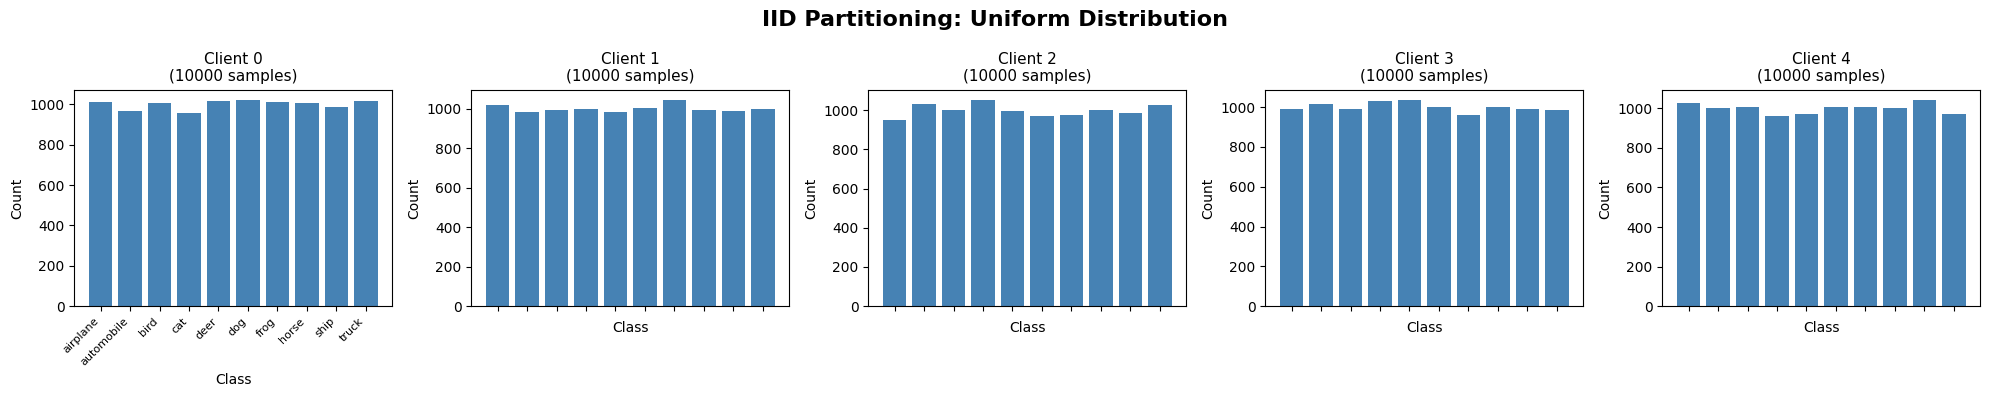

✓ Notice: All clients have roughly equal representation of each class!
  This is ideal for federated learning convergence.


In [19]:
def plot_label_distribution(fds, num_clients, title):
    """Plot label distribution across clients."""
    fig, axes = plt.subplots(1, num_clients, figsize=(20, 4))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for client_id in range(num_clients):
        partition = fds.load_partition(client_id)
        labels = [sample['label'] for sample in partition]
        distribution = np.bincount(labels, minlength=10)
        
        axes[client_id].bar(range(10), distribution, color='steelblue')
        axes[client_id].set_title(f'Client {client_id}\n({len(partition)} samples)', fontsize=11)
        axes[client_id].set_xlabel('Class')
        axes[client_id].set_ylabel('Count')
        axes[client_id].set_xticks(range(10))
        
        # Show class names on x-axis for first client only
        if client_id == 0:
            axes[client_id].set_xticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=8)
        else:
            axes[client_id].set_xticklabels([])
    
    plt.tight_layout()
    plt.show()

plot_label_distribution(fds_iid, num_clients, 'IID Partitioning: Uniform Distribution')

print("✓ Notice: All clients have roughly equal representation of each class!")
print("  This is ideal for federated learning convergence.")

## 2. Label Skew (Dirichlet Partitioning)

**Label Skew** = Non-IID data where different clients have different class distributions

Uses **Dirichlet distribution** controlled by parameter `alpha`:
- **alpha = 1000** (large): Nearly IID, similar to uniform
- **alpha = 1**: Moderate skew
- **alpha = 0.1** (small): Extreme skew, each client has very few classes

### Real-world example:
- Hospital A: Mostly elderly patients
- Hospital B: Mostly young patients
- Each has different disease distributions

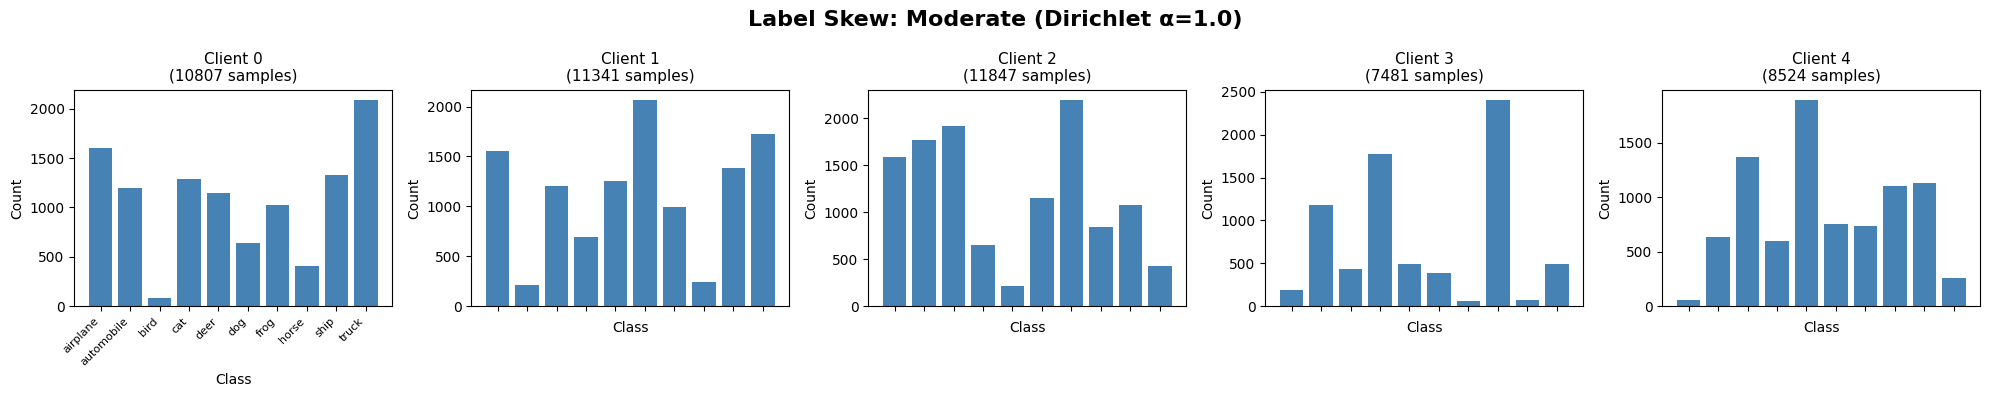

✓ Notice: Some variation in class distribution, but all classes present


In [20]:
# Scenario 1: Moderate label skew (alpha=1.0)
partitioner_dirichlet_moderate = DirichletPartitioner(
    num_partitions=num_clients,
    partition_by="label",
    alpha=1.0,
    min_partition_size=0
)

fds_label_skew_moderate = FederatedDataset(
    dataset=DATASET_NAME,
    partitioners={"train": partitioner_dirichlet_moderate},
)

plot_label_distribution(
    fds_label_skew_moderate, 
    num_clients, 
    'Label Skew: Moderate (Dirichlet α=1.0)'
)

print("✓ Notice: Some variation in class distribution, but all classes present")

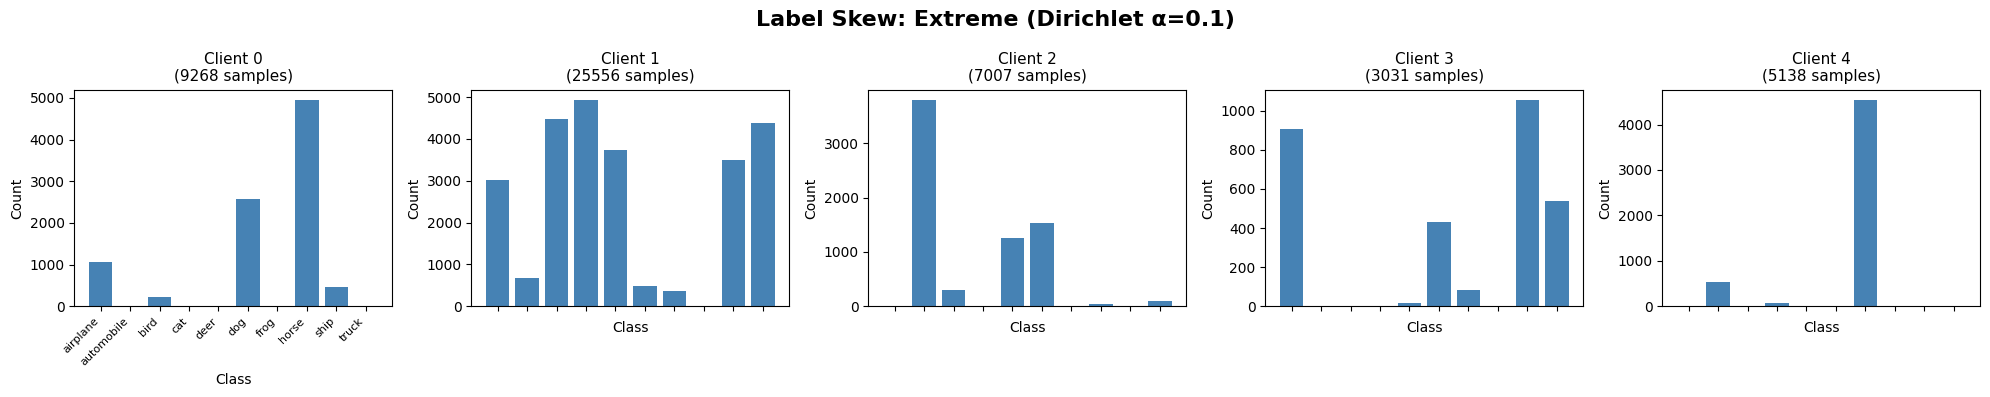

✓ Notice: Each client is dominated by 1-2 classes!
  This is very challenging for federated learning.


In [21]:
# Scenario 2: Extreme label skew (alpha=0.1)
partitioner_dirichlet_extreme = DirichletPartitioner(
    num_partitions=num_clients,
    partition_by="label",
    alpha=0.1,
    min_partition_size=0
)

fds_label_skew_extreme = FederatedDataset(
    dataset=DATASET_NAME,
    partitioners={"train": partitioner_dirichlet_extreme},
)

plot_label_distribution(
    fds_label_skew_extreme, 
    num_clients, 
    'Label Skew: Extreme (Dirichlet α=0.1)'
)

print("✓ Notice: Each client is dominated by 1-2 classes!")
print("  This is very challenging for federated learning.")

## 3. Quantity Skew (Data Volume Imbalance)

**Quantity Skew** = Clients have different amounts of data

Two strategies:
- **Linear**: Gradually increasing data size
- **Exponential**: Exponentially increasing data size

### Real-world example:
- Large hospital: 10,000 patients
- Small clinic: 500 patients

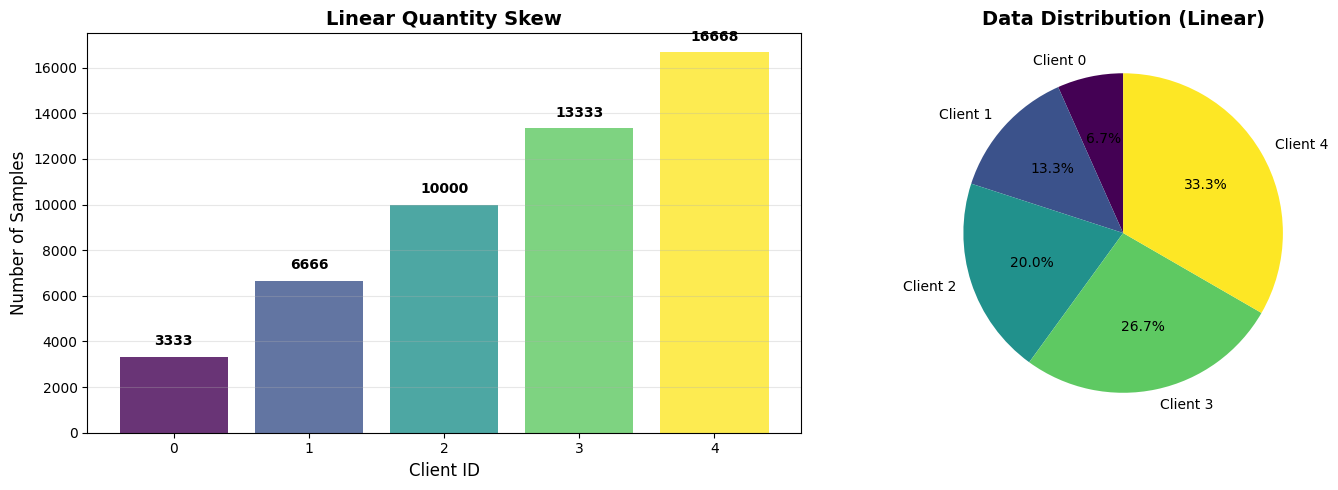


Linear Quantity Skew:
  Client 0: 3,333 samples (6.7%)
  Client 1: 6,666 samples (13.3%)
  Client 2: 10,000 samples (20.0%)
  Client 3: 13,333 samples (26.7%)
  Client 4: 16,668 samples (33.3%)

Total: 50,000 samples


In [23]:
# Linear quantity skew
partitioner_linear = LinearPartitioner(num_partitions=num_clients)

fds_quantity_linear = FederatedDataset(
    dataset=DATASET_NAME,
    partitioners={"train": partitioner_linear},
)

# Get partition sizes
sizes_linear = []
for client_id in range(num_clients):
    partition = fds_quantity_linear.load_partition(client_id)
    sizes_linear.append(len(partition))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Bar chart of sizes
colors = plt.cm.viridis(np.linspace(0, 1, num_clients))
ax1.bar(range(num_clients), sizes_linear, color=colors, alpha=0.8)
ax1.set_xlabel('Client ID', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Linear Quantity Skew', fontsize=14, fontweight='bold')
ax1.set_xticks(range(num_clients))
ax1.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, size in enumerate(sizes_linear):
    ax1.text(i, size + 500, str(size), ha='center', fontsize=10, fontweight='bold')

# Plot 2: Pie chart showing proportion
ax2.pie(sizes_linear, labels=[f'Client {i}' for i in range(num_clients)],
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Data Distribution (Linear)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nLinear Quantity Skew:")
for i, size in enumerate(sizes_linear):
    print(f"  Client {i}: {size:,} samples ({size/sum(sizes_linear)*100:.1f}%)")
print(f"\nTotal: {sum(sizes_linear):,} samples")

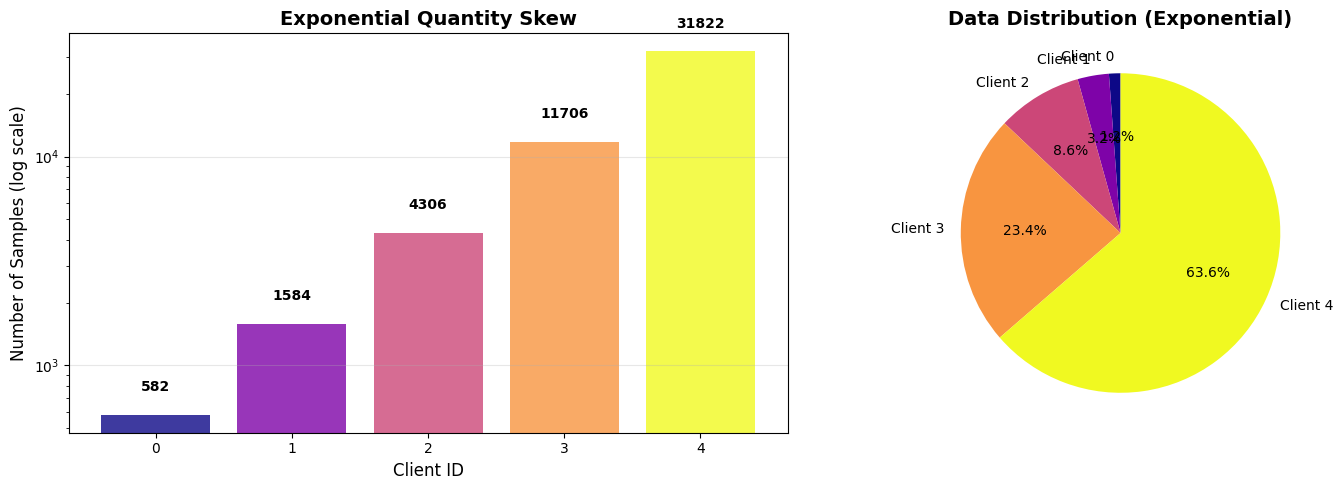


Exponential Quantity Skew:
  Client 0: 582 samples (1.2%)
  Client 1: 1,584 samples (3.2%)
  Client 2: 4,306 samples (8.6%)
  Client 3: 11,706 samples (23.4%)
  Client 4: 31,822 samples (63.6%)

Total: 50,000 samples

Ratio (largest/smallest): 54.7x


In [24]:
# Exponential quantity skew
partitioner_exponential = ExponentialPartitioner(num_partitions=num_clients)

fds_quantity_exponential = FederatedDataset(
    dataset=DATASET_NAME,
    partitioners={"train": partitioner_exponential},
)

# Get partition sizes
sizes_exponential = []
for client_id in range(num_clients):
    partition = fds_quantity_exponential.load_partition(client_id)
    sizes_exponential.append(len(partition))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Bar chart (log scale)
colors = plt.cm.plasma(np.linspace(0, 1, num_clients))
ax1.bar(range(num_clients), sizes_exponential, color=colors, alpha=0.8)
ax1.set_xlabel('Client ID', fontsize=12)
ax1.set_ylabel('Number of Samples (log scale)', fontsize=12)
ax1.set_title('Exponential Quantity Skew', fontsize=14, fontweight='bold')
ax1.set_xticks(range(num_clients))
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, size in enumerate(sizes_exponential):
    ax1.text(i, size * 1.3, str(size), ha='center', fontsize=10, fontweight='bold')

# Plot 2: Pie chart
ax2.pie(sizes_exponential, labels=[f'Client {i}' for i in range(num_clients)],
        autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Data Distribution (Exponential)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nExponential Quantity Skew:")
for i, size in enumerate(sizes_exponential):
    print(f"  Client {i}: {size:,} samples ({size/sum(sizes_exponential)*100:.1f}%)")
print(f"\nTotal: {sum(sizes_exponential):,} samples")
print(f"\nRatio (largest/smallest): {max(sizes_exponential)/min(sizes_exponential):.1f}x")

## 4. Combined: Label Skew + Quantity Skew

In reality, we often have **both** label skew and quantity skew!

This is the most realistic and challenging scenario.

/var/folders/df/c1j0k74n1kqgy27d5rkt12j00000gn/T/ipykernel_27875/2264812718.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, client_id].set_xticklabels([c[:3] for c in CLASS_NAMES], rotation=45, ha='right', fontsize=7)


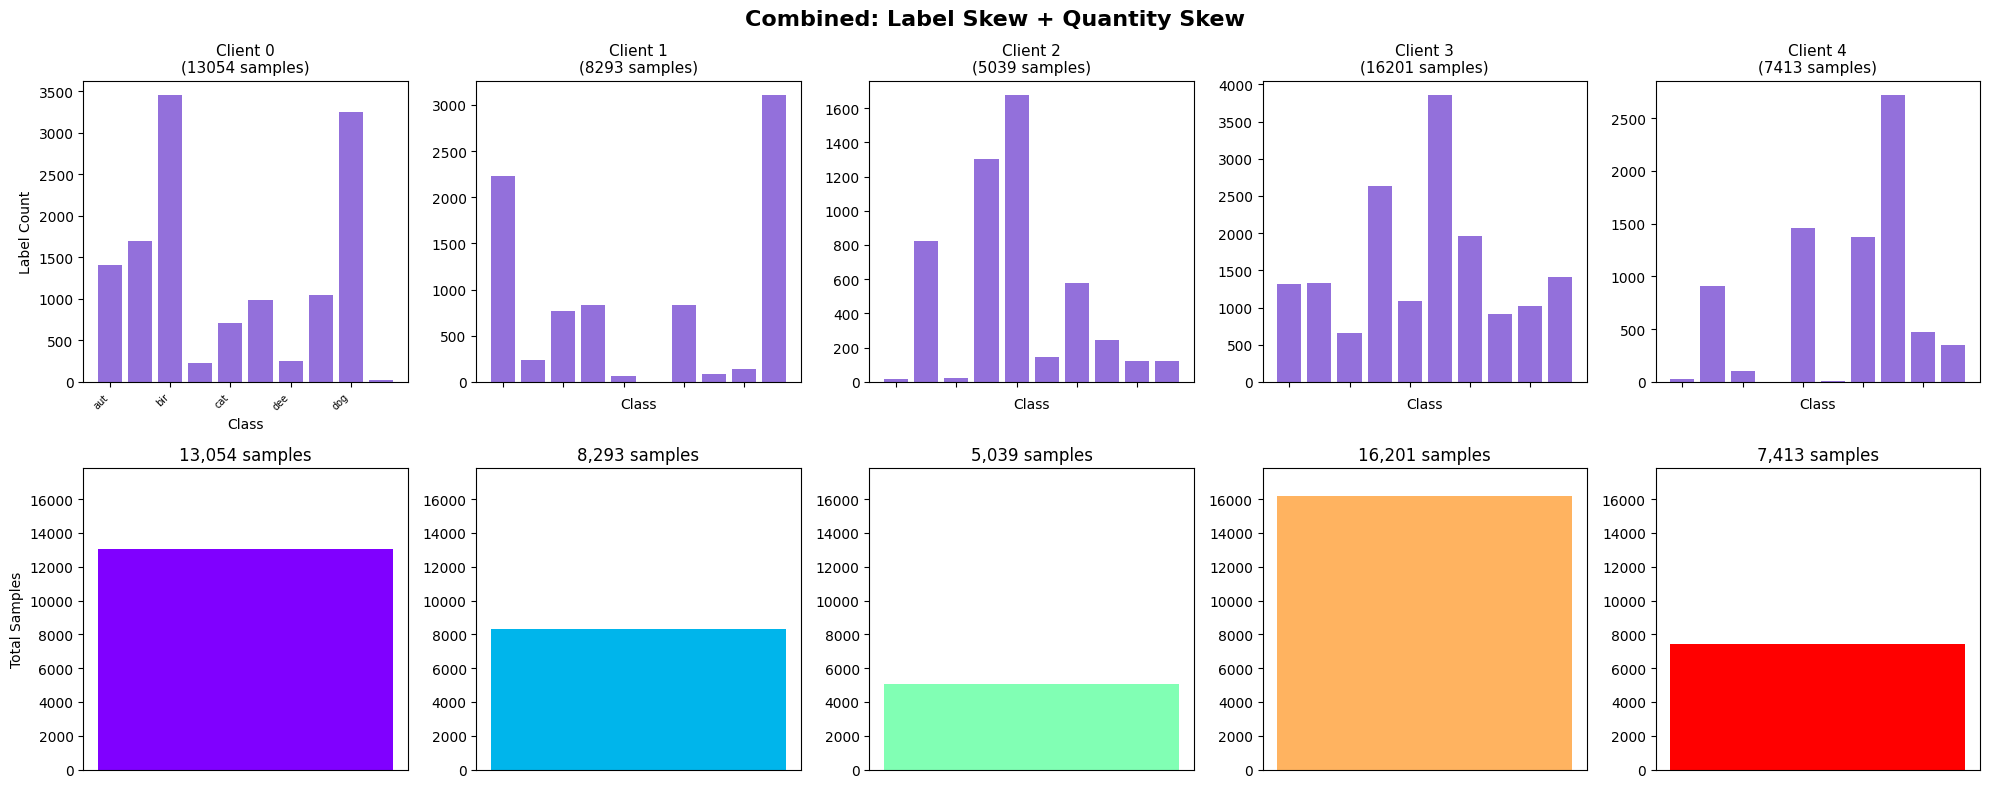


✓ This is the most realistic scenario:
  - Different clients have different label distributions
  - Different clients have different amounts of data
  - Most challenging for federated learning!


In [25]:
# Create combined skew using Dirichlet for both labels and quantities
partitioner_combined = DirichletPartitioner(
    num_partitions=num_clients,
    partition_by="label",
    alpha=0.5,  # Label skew
    min_partition_size=0,
)

# Note: For true quantity skew + label skew, you'd need custom partitioner
# This demonstrates the concept

fds_combined = FederatedDataset(
    dataset=DATASET_NAME,
    partitioners={"train": partitioner_combined},
)

# Visualize both aspects
fig, axes = plt.subplots(2, num_clients, figsize=(20, 8))
fig.suptitle('Combined: Label Skew + Quantity Skew', fontsize=16, fontweight='bold')

sizes_combined = []

# Row 1: Label distribution
for client_id in range(num_clients):
    partition = fds_combined.load_partition(client_id)
    sizes_combined.append(len(partition))
    labels = [sample['label'] for sample in partition]
    distribution = np.bincount(labels, minlength=10)
    
    axes[0, client_id].bar(range(10), distribution, color='mediumpurple')
    axes[0, client_id].set_title(f'Client {client_id}\n({len(partition)} samples)', fontsize=11)
    axes[0, client_id].set_xlabel('Class')
    if client_id == 0:
        axes[0, client_id].set_ylabel('Label Count')
        axes[0, client_id].set_xticklabels([c[:3] for c in CLASS_NAMES], rotation=45, ha='right', fontsize=7)
    else:
        axes[0, client_id].set_xticklabels([])

# Row 2: Total samples per client
colors = plt.cm.rainbow(np.linspace(0, 1, num_clients))
for client_id in range(num_clients):
    axes[1, client_id].bar([0], [sizes_combined[client_id]], color=colors[client_id], width=0.5)
    axes[1, client_id].set_title(f'{sizes_combined[client_id]:,} samples')
    axes[1, client_id].set_xticks([])
    axes[1, client_id].set_ylim(0, max(sizes_combined) * 1.1)
    if client_id == 0:
        axes[1, client_id].set_ylabel('Total Samples')

plt.tight_layout()
plt.show()

print("\n✓ This is the most realistic scenario:")
print("  - Different clients have different label distributions")
print("  - Different clients have different amounts of data")
print("  - Most challenging for federated learning!")